# **1. Download das Bibliotecas**

In [17]:
#%pip install river pandas==2.2.2 scipy==1.13.1 numpy==1.26.1

In [18]:
#%pip install matplotlib yfinance scikit-learn scikit-optimize

# **2. Importações**

## Geral

In [19]:
# Importação de libs auxiliares
import numpy as np
import pandas as pd

# Importando as classes refatoradas
from preprocessamento.SeriesProcessor import SeriesProcessor
from otimizador.Optimizer import OtimizadorModelosSklearn
from avaliacao.AvaliadorDriftBase import AvaliadorBatch
from avaliacao.AvaliadorDriftBase import AvaliadorPassivo
from avaliacao.AvaliadorDriftBase import AvaliadorFramework
from utils.Visualizer import Visualizer

# limpar o log
import warnings
#warnings.filterwarnings("ignore")

## Importação dos Detectores e Regressores Off-line e On-line

In [20]:
# importando o framework
from frameLiedson.FrameLiedson import FrameLiedson

In [ ]:
# Importando detectores de drift
from detectores.ADWINDetector import ADWINDetector
from detectores.DDMDetector import DDMDetector
from detectores.EDDMDetector import EDDMDetector
from detectores.FHDDMDetector import FHDDMDetector
from detectores.HDDM_ADetector import HDDM_ADetector
from detectores.PageHinkleyDetector import PageHinkleyDetector
from detectores.HDDM_WDetector import HDDM_WDetector
from detectores.KSWINDetector import KSWINDetector

In [22]:
# Importando modelos offline
from regressores.modelosOffline.LinearRegressionModelo import LinearRegressionModelo
from regressores.modelosOffline.KneighborsRegressorModelo import KneighborsRegressorModelo
from regressores.modelosOffline.LassoRegressionModelo import LassoRegressionModelo
from regressores.modelosOffline.RidgeRegressionModelo import RidgeRegressionModelo
from regressores.modelosOffline.SVRModelo import SVRModelo
from regressores.modelosOffline.RandomForestModelo import RandomForestModelo
from regressores.modelosOffline.MLPRegressorModelo import MLPRegressorModelo

In [23]:
# Importando modelos online
from regressores.modelosOnline.BayesianLinearRegressionModelo import BayesianLinearRegressionModelo
from regressores.modelosOnline.HoeffdingTreeRegressorModelo import HoeffdingTreeRegressorModelo
from regressores.modelosOnline.KNNRegressorOnlineModelo import KNNRegressorOnlineModelo
from regressores.modelosOnline.LinearRegressionOnlineModelo import LinearRegressionOnlineModelo
from regressores.modelosOnline.MLPRegressorOnlineModelo import MLPRegressorOnlineModelo
from regressores.modelosOnline.OSELM import OSELMModelo

# **3. Dados e Pré-processamento**

## Séries Temporais

In [24]:
# Lista de séries temporais disponíveis
series = [
    "AAPL",
    "B3SA3.SA",
    "IXIC",
    "DJI",
    "GSPC",
    "BVSP",
    "USDBRLX"
]

In [25]:
#SeriesProcessor.baixar_e_salvar_series(series)

## Parâmetros de processamento

In [26]:
# Definindo parâmetros para processamento
tamanho_batch = 300
lags = 10
serie_escolhida = series[0]
print(f"Processando série: {serie_escolhida}")

Processando série: AAPL


## Processamento dos dados

In [27]:
# Baixando os dados da ação
serie_temporal = SeriesProcessor.carregar_serie_csv(serie_escolhida)

# Normalizando a série temporal
serie_temporal = SeriesProcessor.normalizar_serie(serie_temporal)
print(f"Shape da série após normalização: {serie_temporal.shape}")

# Gerando janelas temporais
X, Y = SeriesProcessor.criar_janela_temporal(serie_temporal, lags)
print(f"Shape dos dados de entrada: {X.shape}")
print(f"Shape dos dados de saída: {Y.shape}")

Shape da série após normalização: (11189, 1)
Shape dos dados de entrada: (11179, 10)
Shape dos dados de saída: (11179, 1)


# **4. Otimização de Hiperparâmetros**

In [28]:
arquivo_parametros = "melhores_parametros.json"
otimizador = OtimizadorModelosSklearn(n_iter=20)

In [29]:
melhores_parametros = otimizador.otimizar(
    X[tamanho_batch:], 
    Y[tamanho_batch:], 
    salvar_em = arquivo_parametros)

# **5. Definição dos Modelos**

## Regressores off-line

In [30]:
modelos_offline = [
    LinearRegressionModelo,
    KneighborsRegressorModelo,
    LassoRegressionModelo,
    MLPRegressorModelo,  
    RandomForestModelo,
    RidgeRegressionModelo,
    SVRModelo
]

## Regressores on-line

In [31]:
modelos_online = [
        BayesianLinearRegressionModelo,
        HoeffdingTreeRegressorModelo,
        KNNRegressorOnlineModelo,
        LinearRegressionOnlineModelo
    ]

# **6. Prequential com Detecção de Drift**

In [32]:
avaliador = AvaliadorBatch()
predicoes_ativo, deteccoes_ativo, mae_ativo = avaliador.executar_avaliacao(X, Y, tamanho_batch, LinearRegressionModelo, KSWINDetector)


Drift detectado para LR + KSWIN nos índices: [475, 1158, 1556, 2035, 2565, 3459, 4077, 4475, 4975, 5485, 6062, 6679, 7084, 7577, 7977, 8736, 9525, 9938, 10977]


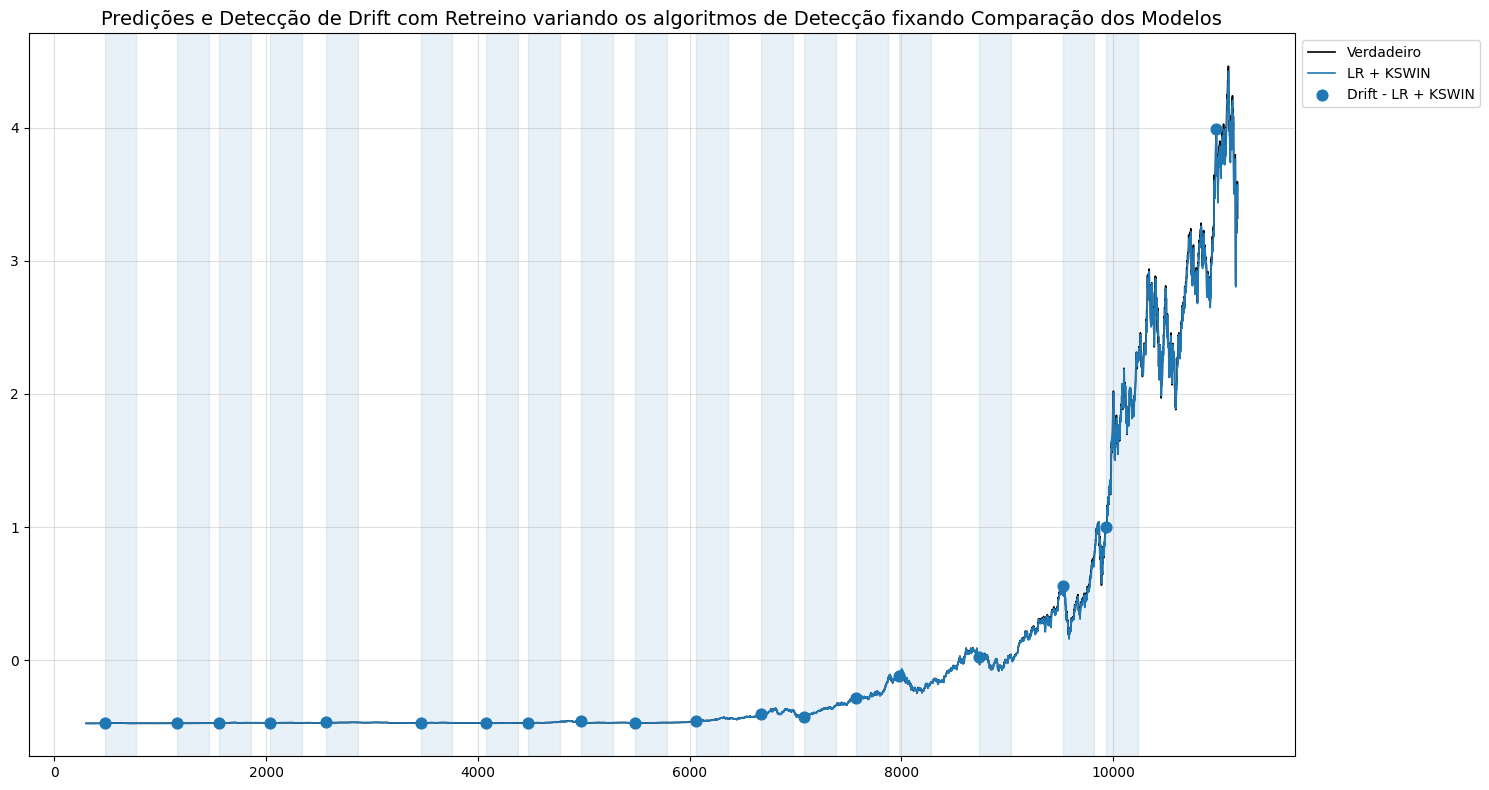

In [33]:
# Plotando os resultados
Visualizer.plotar_resultados_multi(Y,
                  [predicoes_ativo],
                  ["LR + KSWIN"],
                  {"LR + KSWIN": deteccoes_ativo},
                  tamanho_batch,
                  detector_or_modelo="Comparação dos Modelos",
                  )


# **7. Prequential Passivo**

In [34]:
avaliador = AvaliadorPassivo()
predicoes_passivo, mae_passivo = avaliador.executar_avaliacao(X, Y, tamanho_batch, OSELMModelo)


Nenhum drift detectado para BayesianLinearRegressionModelo.


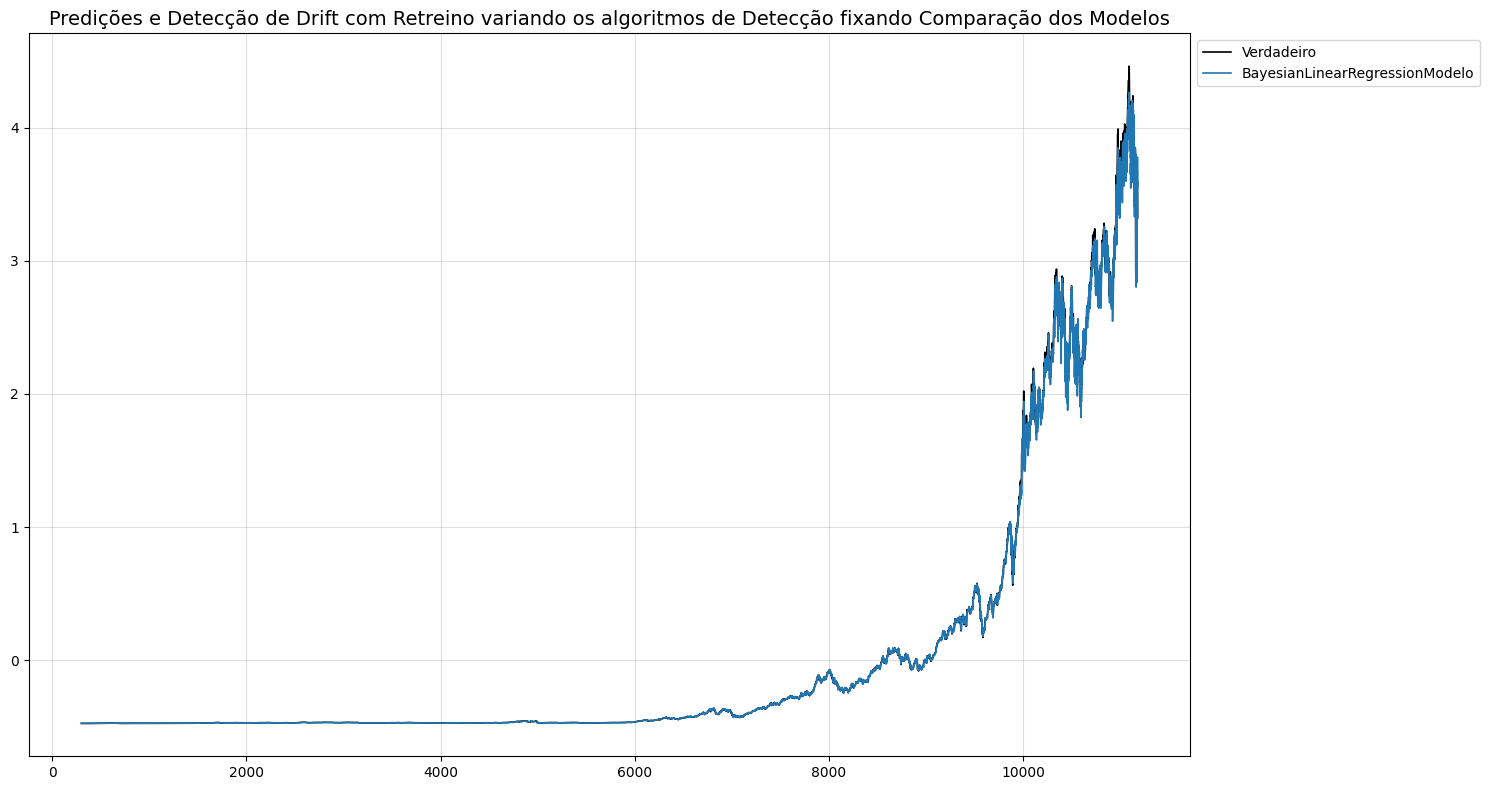

In [35]:
# Plotando os resultados
Visualizer.plotar_resultados_multi(Y,
                  [predicoes_passivo],
                  ["BayesianLinearRegressionModelo"],
                  {"BayesianLinearRegressionModelo": None},
                  tamanho_batch,
                  detector_or_modelo="Comparação dos Modelos",
                  )

# **8. Prequential Passivo com Drift**

In [36]:
avaliador = AvaliadorFramework()
predicoes_ativo_online, deteccoes_ativo_online, mae_ativo_online = avaliador.executar_avaliacao(X, Y, tamanho_batch, BayesianLinearRegressionModelo, KSWINDetector)


Drift detectado para BayesianLinearRegressionModelo + KSWIN nos índices: [398, 833, 1233, 1672, 2073, 2505, 2941, 3466, 3872, 4306, 4735, 5142, 5591, 6020, 6445, 6847, 7247, 7714, 8131, 8549, 8962, 9370, 9892, 10336, 10983]


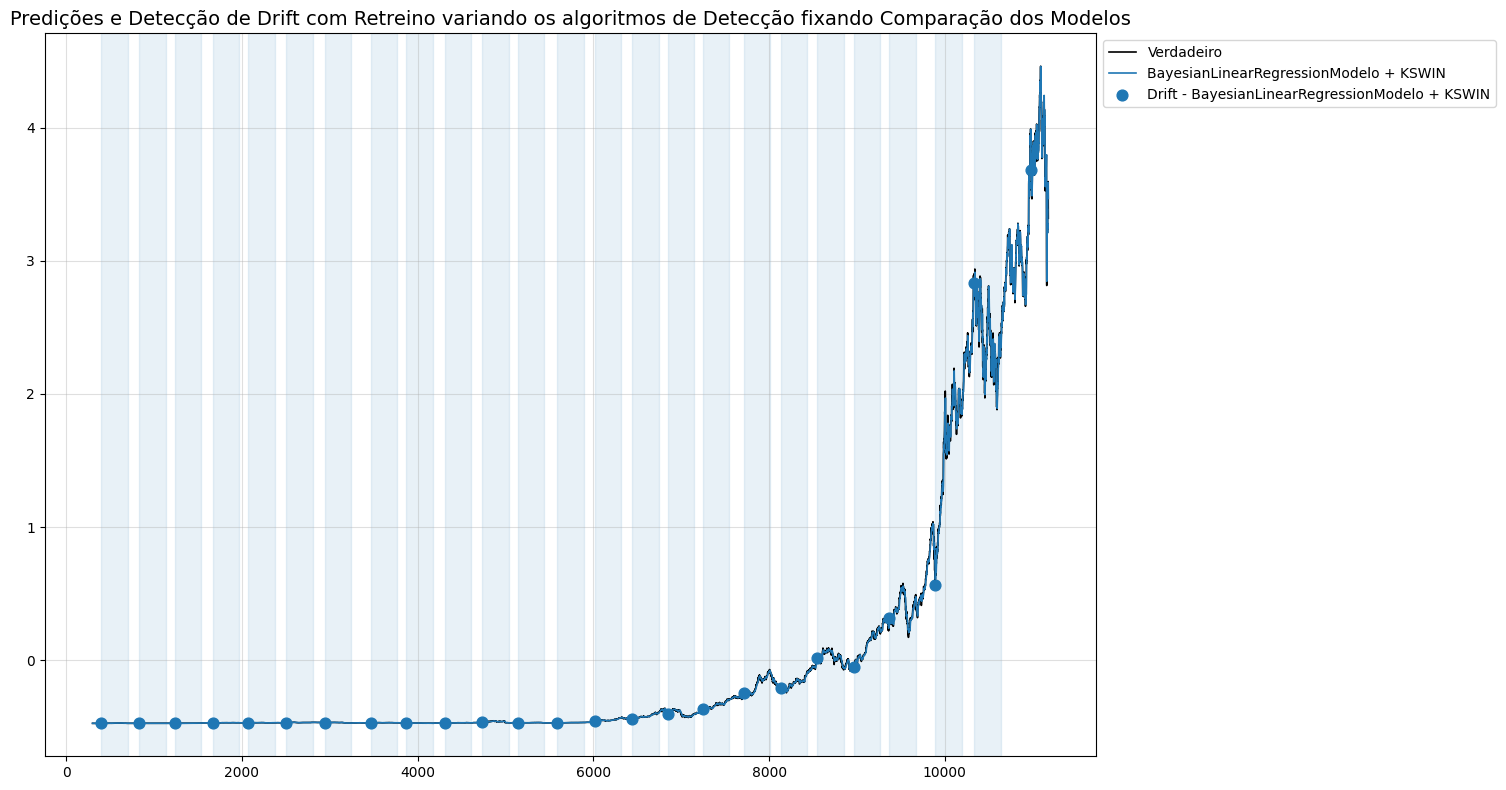

In [37]:
# Plotando os resultados
Visualizer.plotar_resultados_multi(Y,
                  [predicoes_ativo_online],
                  ["BayesianLinearRegressionModelo + KSWIN"],
                  {"BayesianLinearRegressionModelo + KSWIN": deteccoes_ativo_online},
                  tamanho_batch,
                  detector_or_modelo="Comparação dos Modelos",
                  )

# **9. Framework Liedson**

In [ ]:
framework = FrameLiedson(BayesianLinearRegressionModelo, KSWINDetector, 30, 100)
predicoes_frame, deteccoes_frame, mae_frame = framework.prequential(X, Y, tamanho_batch)


Drift detectado para Liedson nos índices: [398, 829, 1231, 1668, 2071, 2508, 2938, 3463, 3871, 4304, 4740, 5228, 5649, 6095, 6583, 6998, 7403, 7804, 8394, 8878, 9365, 9891, 10334, 10979]


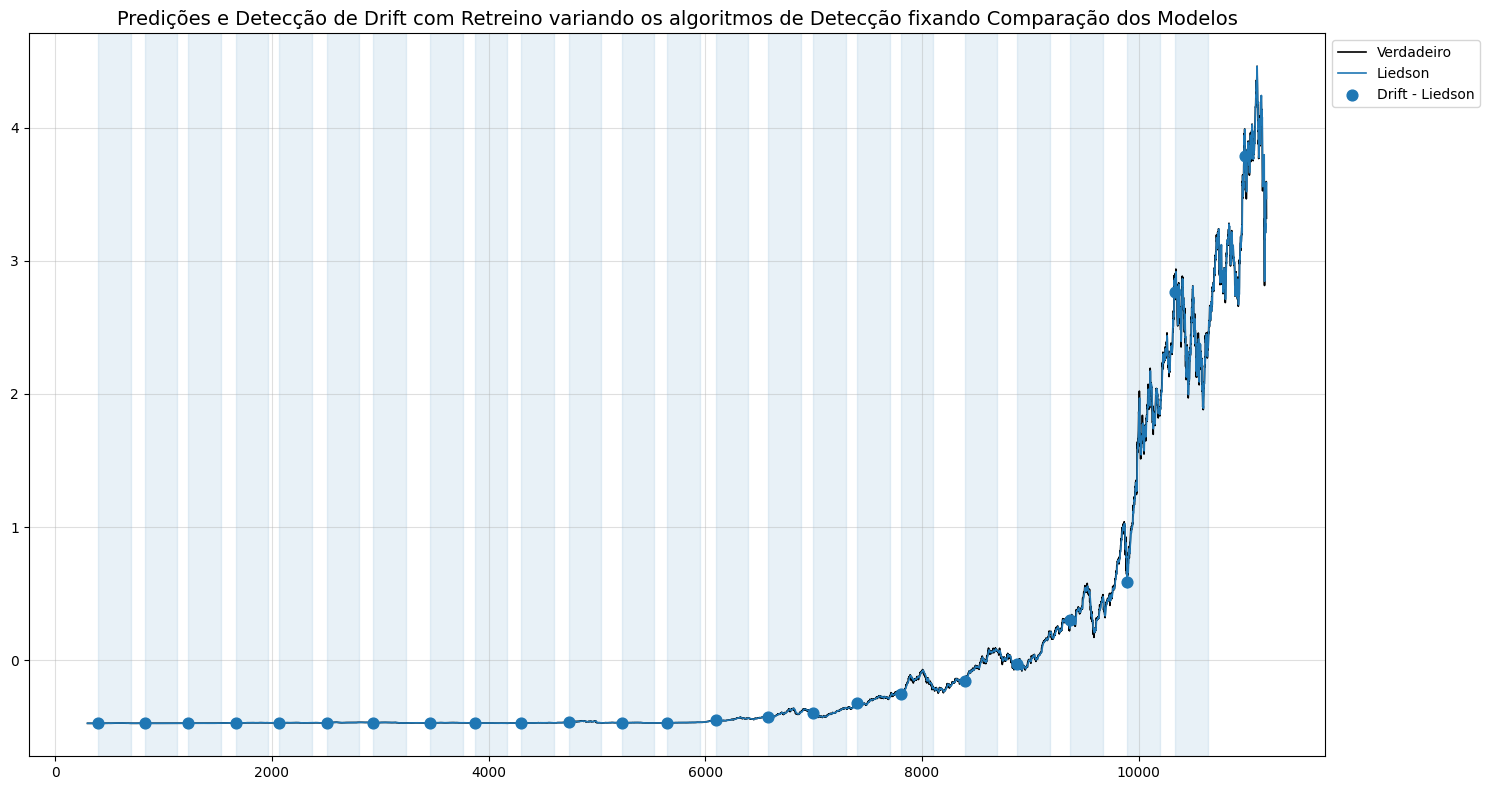

In [ ]:
# Plotando os resultados
Visualizer.plotar_resultados_multi(Y,
                  [predicoes_frame],
                  ["Liedson"],
                  {"Liedson": deteccoes_frame},
                  tamanho_batch,
                  detector_or_modelo="Comparação dos Modelos",
                  )

# **10. Comparação**

In [ ]:
print(mae_ativo)
print(mae_passivo)
print(mae_ativo_online)
print(mae_frame)

[0.00699636]
[0.01106985]
[0.00796801]
[0.0080043]



Drift detectado para Liedson nos índices: [398, 829, 1231, 1668, 2071, 2508, 2938, 3463, 3871, 4304, 4740, 5228, 5649, 6095, 6583, 6998, 7403, 7804, 8394, 8878, 9365, 9891, 10334, 10979]


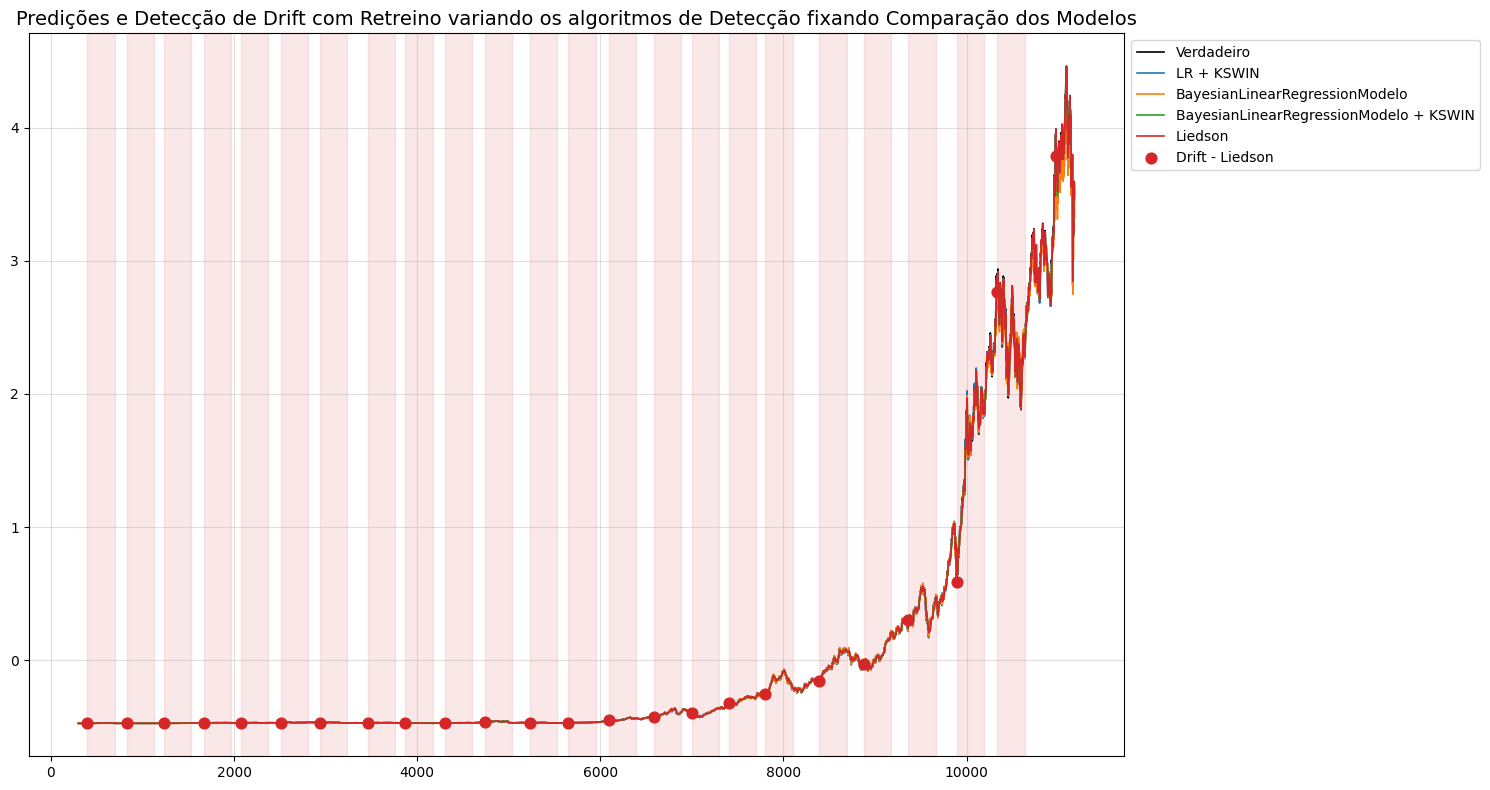

In [ ]:
# Plotando os resultados
Visualizer.plotar_resultados_multi(Y,
                  [predicoes_ativo,
                   predicoes_passivo,
                   predicoes_ativo_online,
                   predicoes_frame],
                  ["LR + KSWIN",
                   "BayesianLinearRegressionModelo",
                   "BayesianLinearRegressionModelo + KSWIN",
                   "Liedson"],
                  {"Liedson": deteccoes_frame},
                  tamanho_batch,
                  detector_or_modelo="Comparação dos Modelos",
                  )